# 인공지능 작사가 만들기

[1. 데이터 처리](#1.-데이터-처리)

[2. 모델 설계](#2.-모델-설계)

[3. 모델 훈련하기](#3.-모델-훈련하기)

[4. 가사 만들기](#4.-가사-만들기)

## 1. 데이터 처리

[가사 데이터 읽어오기](https://www.kaggle.com/paultimothymooney/poetry) 출처 : kaggle

In [1]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']


데이터 전처리 : 이때 노래 가사 특성 상 토큰의 개수가 15개가 넘는 경우는 제외해 준다.

In [2]:
import re
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2  
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    if len(sentence.split()) > 15 : #token 개수 제한
        sentence = ""
        
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample   asdsad   dsfsdf  dfgfd fdg   fgdfg  fgd fdgf dfgfd dfgdfg dfgfdg gdfgfd sentence."))

전처리 실행

In [3]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue #공백 무시
    if sentence[-1] == ":": continue # : 무시
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence) == 0: continue #token 개수 제한
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
print("정제된 문장 수 : ",len(corpus))
corpus[:10]

정제된 문장 수 :  156013


['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> i would have made you leave your key <end>']

토큰화 진행

In [4]:
import tensorflow as tf
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   70  248 ...    0    0    0]
 [   2    4   53 ...    0    0    0]
 [   2    4 1077 ...    0    0    0]
 ...
 [   2    8    4 ...    0    0    0]
 [   2   44   17 ...    0    0    0]
 [   2    6  172 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fbf87cb0f90>


tensor 확인

In [5]:
print(tensor[:3, :10]) #2로 시작 ? 2가 <start>이기 때문에

[[   2   70  248    4   53  708    3    0    0    0]
 [   2    4   53 6263    3    0    0    0    0    0]
 [   2    4 1077  531    4  104   80  192  257    7]]


voca 확인

In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


소스 문장과 타겟 문장 생성

In [7]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0]) #target이기 때문에 2 <start> 제거

[  2  70 248   4  53 708   3   0   0   0   0   0   0   0]
[ 70 248   4  53 708   3   0   0   0   0   0   0   0   0]


train/test split (80/20)

In [8]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 42)

In [9]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


#### tf.data.Dataset 생성

In [10]:
def tensor_to_dataset(src_input,tgt_input):
    
    BUFFER_SIZE = len(src_input)
    BATCH_SIZE = 256
    steps_per_epoch = len(src_input) // BATCH_SIZE

     # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
    VOCAB_SIZE = tokenizer.num_words + 1   

    # 준비한 데이터 소스로부터 데이터셋을 만듭니다
    # 데이터셋에 대해서는 아래 문서를 참고하세요
    # 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = tensor_to_dataset(enc_train, dec_train)
valid_dataset = tensor_to_dataset(enc_val, dec_val)

## 2. 모델 설계하기

embedding_size = 256   
hidden_size = 2048

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size): #생성자 :  Layer 정의
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) 
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x): #호출 함수
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

model.summary 보기 위해서 임의 입력

In [12]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample) #256 X 14 X 12001 : batch size , LSTM sequence 길이 , voca 수

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 7.26482685e-05, -2.67819396e-05, -6.48622881e-05, ...,
         -2.12748288e-04, -7.71218474e-05,  5.34010105e-05],
        [ 5.58129977e-05,  3.95447023e-05, -9.06040150e-05, ...,
         -4.81458730e-04, -1.85940633e-04,  2.40119582e-04],
        [ 7.59100512e-05, -1.12036250e-04, -2.85922724e-04, ...,
         -7.76646251e-04, -3.37376900e-04,  2.96595681e-04],
        ...,
        [-1.14621362e-03,  1.07770192e-03, -1.59156625e-04, ...,
          8.02196038e-04, -1.13827817e-03,  6.21677609e-04],
        [-1.16299489e-03,  1.47716980e-03, -1.20107667e-04, ...,
          1.13130396e-03, -1.00180379e-03,  7.06903462e-04],
        [-1.19458663e-03,  1.89305609e-03, -8.60659129e-05, ...,
          1.44421379e-03, -8.38510634e-04,  7.87063793e-04]],

       [[ 7.26482685e-05, -2.67819396e-05, -6.48622881e-05, ...,
         -2.12748288e-04, -7.71218474e-05,  5.34010105e-05],
        [ 8.80110310e-05,  1.34142974e-04, -7

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  18882560  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 훈련하기

8 epoch 이후로 val_loss가 점점 증가해 과대 적합이 발생했음을 알 수 있다.

In [14]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
hist = model.fit(train_dataset,epochs=10,validation_data=valid_dataset) #10epoch

Epoch 1/10
487/487 [==============================] - 447s 912ms/step - loss: 3.8752 - val_loss: 2.9796
Epoch 2/10
487/487 [==============================] - 444s 912ms/step - loss: 2.8732 - val_loss: 2.7116
Epoch 3/10
487/487 [==============================] - 445s 913ms/step - loss: 2.5485 - val_loss: 2.5244
Epoch 4/10
487/487 [==============================] - 446s 915ms/step - loss: 2.2280 - val_loss: 2.3824
Epoch 5/10
487/487 [==============================] - 445s 913ms/step - loss: 1.9319 - val_loss: 2.2791
Epoch 6/10
487/487 [==============================] - 442s 908ms/step - loss: 1.6690 - val_loss: 2.2050
Epoch 7/10
487/487 [==============================] - 443s 909ms/step - loss: 1.4419 - val_loss: 2.1630
Epoch 8/10
487/487 [==============================] - 444s 912ms/step - loss: 1.2680 - val_loss: 2.1458
Epoch 9/10
487/487 [==============================] - 442s 909ms/step - loss: 1.1394 - val_loss: 2.1487
Epoch 10/10
487/487 [==============================] - 445s 915m

#### 갑자기 마크다운으로 바뀌어서 loss 그래프가 사라져서 따로 첨부합니다.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
plt.show()

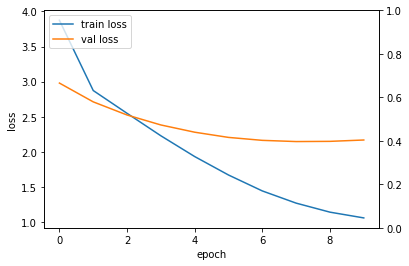

## 4. 가사 만들기

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

## 생성된 가사

In [35]:
generate_text(model, tokenizer, init_sentence="<start> card", max_len=20)

'<start> card to me <end> '

In [38]:
generate_text(model, tokenizer, init_sentence="<start> he is", max_len=20)

'<start> he is he is cmon whats his name <end> '

In [39]:
generate_text(model, tokenizer, init_sentence="<start> love", max_len=20)

'<start> love is a temple <end> '

In [41]:
generate_text(model, tokenizer, init_sentence="<start> lord", max_len=20)

'<start> lord , show me the way <end> '

In [50]:
generate_text(model, tokenizer, init_sentence="<start> why", max_len=20)

'<start> why do we scream at each other <end> '

In [55]:
generate_text(model, tokenizer, init_sentence="<start> sometimes", max_len=20)

'<start> sometimes i hear death knockin at my front do <end> '

In [56]:
generate_text(model, tokenizer, init_sentence="<start> whenever", max_len=20)

'<start> whenever you hear the sound don t be alarmed <end> '

In [60]:
generate_text(model, tokenizer, init_sentence="<start> whatever", max_len=20)

'<start> whatever happens , don t you let go of my hand <end> '

In [63]:
generate_text(model, tokenizer, init_sentence="<start> gotta", max_len=20)

'<start> gotta get a leadway <end> '

In [69]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you , i love you <end> '

___

## 정리

- lyric 데이터를 통해 LSTM을 훈련시켜서 임의의 단어를 입력 받아 단어를 생성하는 모델을 만들었다. 

이때 전처리 시 가사 특성 상 토큰이 15개가 넘어가는 문장은 데이터에서 제외했다.

- LSTM을 통해 모델을 구성했으며 학습 시 8 epoch 이상 부터 valid loss가 증가하는 것으로 보아 **overfitting**이 발생했다.

___

overfitting을 해결하기 위해 regularization 기법 중 dropout을 사용했다. 

dropout은 LSTM 특성 상 별도의 dropout layer를 구성하는 것이 아닌 tf.keras.layers.LSTM(dropout = 0.4, recurrent_dropout = 0.4)를 통해 진행했다.

참고 링크 https://wjddyd66.github.io/keras/Keras(4-2)/

또한 dropout rate의 경우 일반적인 딥러닝 네트워크와 다르게 0.4로 설정했다.    
'An Exploration of Dropout with RNNs for Natural Language Inference' 라는 논문의 실험 결과를 참고했다.

#### 새로 구성한 네트워크의 loss 그래프는 다음과 같았다.

![image](https://user-images.githubusercontent.com/86637320/127311027-f85a99db-416c-411d-8183-2c48560e57f2.png)

##### 빨강 : val_loss , 노랑 : loss

이 경우 epoch 10이 될 때까지 val_loss와 loss가 꾸준히 감소하는 것이 확인돼 overfitting이 발생하지 않았다. 과제 제한 사항(10 epoch 이내)상 epoch를 더 늘리진 않았다.